In [1]:
import copy
import numpy as np
import laspy as lp
import open3d as o3d
import pyvista as pv 

def to_open3d(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    return pcd

def las_to_open3d(las_source_path, target_path):
    las = lp.read(las_source_path)
    points = np.vstack((las.x, las.y, las.z)).transpose()
    pcd = to_open3d(points)
    o3d.io.write_point_cloud(target_path, pcd)

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

def get_ground_points(las_source_path, salmuera):
    las = lp.read(las_source_path)
    points = np.vstack((las.x, las.y, las.z)).transpose()
    data_points = np.hstack((points,
                        np.expand_dims(las.return_number, -1),
                        np.expand_dims(las.number_of_returns, -1)))
    one_return = data_points[(data_points[:, -1] == 1)][:, :3]
    return one_return[one_return[:,2] > salmuera] 

def view_cloud_pv(points):
    cloud = pv.PolyData(points)
    plotter = pv.Plotter()
    plotter.add_mesh(cloud, color='blue')
    plotter.show()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:
rasantes = {
    'km11': 2300.382,  
    'km12': 2300.345,   
    'km13': 2300.372,
    #'3a': 2300.305, #marzo
    '3a': 2300.326, #14042025
    #'2a': z, #marzo
    '2a': 2300.416, #14042025
    'pam2': 2300.572  
}

salmueras = {
    'km11': 2300.866,
    'km12': 2300.582,
    'km13': 2300.647,
    'pam2': 2302.185, #marzo
    'pam2':2302.221, #23042025
    #'pam2':2301.999, #14042025
    #'2a': 2301.129, #marzo
    #'3a': 2300.978, #marzo
    '2a': 2300.416, #14042025
    '3a': 2300.953 #14042025
}

POZA = '3a'
THRESHOLD = 0.02
SALMUERA = salmueras.get(POZA, None)
RASANTE = rasantes.get(POZA, None)
RASANTEV1 = 2300.305
RASANTEV2 = 2300.326
TRANS_INIT = np.asarray([[1.0, 0.0, 0.0, 0.0], 
                         [0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0], 
                         [0.0, 0.0, 0.0, 1.0]])

In [11]:
source_path = '/home/diego/Downloads/data_sqm/clasificadas_por_poza_nueva_exportacion/3-a_100m_10ms_100khz_plena-luz_0_0_poza.las'
target_path = '/home/diego/Downloads/data_sqm/14-04-2025/14-04-25 100m&150m 100Khz 10ms/3-a_100m_10ms_100khz_plena-luz_0_0_poza.las'

In [12]:
src_ground_points = get_ground_points(source_path, SALMUERA)
#view_cloud_pv(src_ground_points)
pcd_src_ground_points = to_open3d(src_ground_points)

dst_ground_points = get_ground_points(target_path, SALMUERA)
#view_cloud_pv(dst_ground_points)
pcd_dst_ground_points = to_open3d(dst_ground_points)

pcd_src_ground_points.estimate_normals()
pcd_dst_ground_points.estimate_normals()

print("Apply point-to-plane ICP")
reg_p2l = o3d.pipelines.registration.registration_icp(
            pcd_src_ground_points, 
            pcd_dst_ground_points, 
            THRESHOLD, 
            TRANS_INIT,
            o3d.pipelines.registration.TransformationEstimationPointToPlane()
        )

#draw_registration_result(pcd_src_ground_points, pcd_dst_ground_points, TRANS_INIT)


print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)

transformation = reg_p2l.transformation

KeyboardInterrupt: 

In [13]:
# # Read existing LAS
# las = lp.read(source_path)

# src_las_data_points_transformed = np.dot(transformation[:3, :3], las.xyz.T).T + transformation[:3, 3]

# # Overwrite coordinates with your transformed point cloud
# las.x = src_las_data_points_transformed[:, 0]
# las.y = src_las_data_points_transformed[:, 1]
# las.z = src_las_data_points_transformed[:, 2]

# Save as a new file (don’t overwrite original unless sure)
path_las_transformed = source_path.replace('.las', '_transformed.las')
#print(f"Saving transformed LAS to {path_las_transformed}")
#las.write(path_las_transformed)

In [14]:
import numpy as np
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator
import rasterio
from rasterio.transform import from_origin


def generate_dem(points, rasante, x_min, x_max, y_min, y_max, output_filename=None, grid_spacing=None):
    # Extraer y procesar coordenadas
    x, y, z = points[:, 0], points[:, 1], points[:, 2] - rasante
    z = np.clip(z, 0, 4)

    # Calcular espaciado de la grilla
    if grid_spacing is None:
        dx = np.diff(x)
        dy = np.diff(y)
        point_spacing = np.mean(np.sqrt(dx**2 + dy**2))
        grid_spacing = point_spacing

    # Crear dimensiones de la grilla
    #x_min, x_max = np.min(x), np.max(x)
    #y_min, y_max = np.min(y), np.max(y)
    
    cols = int(np.ceil((x_max - x_min) / grid_spacing))
    rows = int(np.ceil((y_max - y_min) / grid_spacing))

    # Binning para promedio de elevaciones
    grid_sum = np.zeros((rows, cols))
    grid_count = np.zeros((rows, cols))
    
    xi = ((x - x_min) / grid_spacing).astype(int)
    yi = ((y_max - y) / grid_spacing).astype(int)
    
    np.add.at(grid_sum, (yi, xi), z)
    np.add.at(grid_count, (yi, xi), 1)
    
    dem = np.divide(grid_sum, grid_count, where=grid_count != 0)
    dem[grid_count == 0] = np.nan

    # # Interpolación combinada lineal + nearest
    # mask = ~np.isnan(dem)
    # y_coords, x_coords = np.where(mask)
    
    # # Coordenadas de los puntos válidos
    # xx = x_min + (x_coords + 0.5) * grid_spacing
    # yy = y_max - (y_coords + 0.5) * grid_spacing
    
    # # Primera interpolación lineal
    # linear_interp = LinearNDInterpolator(np.column_stack((xx, yy)), dem[mask])
    # grid_x, grid_y = np.meshgrid(
    #     x_min + (np.arange(cols) + 0.5) * grid_spacing,
    #     y_max - (np.arange(rows) + 0.5) * grid_spacing
    # )
    
    # dem_filled = dem.copy()
    # nan_mask = np.isnan(dem)
    # dem_filled[nan_mask] = linear_interp(grid_x[nan_mask], grid_y[nan_mask])

    # # Segunda interpolación nearest para NaN residuales
    # if np.isnan(dem_filled).any():
    #     nearest_interp = NearestNDInterpolator(np.column_stack((xx, yy)), dem[mask])
    #     residual_nan = np.isnan(dem_filled)
    #     dem_filled[residual_nan] = nearest_interp(grid_x[residual_nan], grid_y[residual_nan])

    # # Guardar el DEM
    # if output_filename is not None:
    #     transform = from_origin(
    #         x_min - grid_spacing/2,
    #         y_max + grid_spacing/2,
    #         grid_spacing,
    #         grid_spacing
    #     )
        
    #     with rasterio.open(
    #         output_filename,
    #         'w',
    #         driver='GTiff',
    #         height=rows,
    #         width=cols,
    #         count=1,
    #         dtype=dem_filled.dtype,
    #         crs=None,
    #         transform=transform,
    #     ) as dst:
    #         dst.write(dem_filled, 1)

    #     print(f"DEM guardado exitosamente en: {output_filename}")
    
    # return dem_filled
    return dem

def get_point(path, salmuera):
    las = lp.read(path)
    points = np.vstack((las.x, las.y, las.z)).transpose()
    return points[points[:,2] < salmuera]

In [15]:
print(path_las_transformed)
points_a = get_point(path_las_transformed, SALMUERA)
points_b = get_point(target_path, SALMUERA)

xmin, xmax = np.min([np.min(points_a[:,0]), np.min(points_b[:,0])]), np.max([np.max(points_a[:,0]), np.max(points_b[:,0])])
ymin, ymax = np.min([np.min(points_a[:,1]), np.min(points_b[:,1])]), np.max([np.max(points_a[:,1]), np.max(points_b[:,1])])

# source = to_open3d(points_a)
# target = to_open3d(points_b)
# draw_registration_result(source, target, transformation)

dem_a = generate_dem(points_a, RASANTEV1, xmin, xmax, ymin, ymax, grid_spacing=0.17)  
dem_b = generate_dem(points_b, RASANTEV2, xmin, xmax, ymin, ymax, grid_spacing=0.17)

/home/diego/Downloads/data_sqm/clasificadas_por_poza_nueva_exportacion/3-a_100m_10ms_100khz_plena-luz_0_0_poza_transformed.las


In [17]:
print(f'vuelo 1 sal promedio: {np.mean(points_a[:,2] - RASANTEV1)*100}')
print(f'vuelo 2 sal promedio: {np.mean(points_b[:,2] - RASANTEV2)*100}')

vuelo 1 sal promedio: 39.03129616532058
vuelo 2 sal promedio: 44.24670350118177


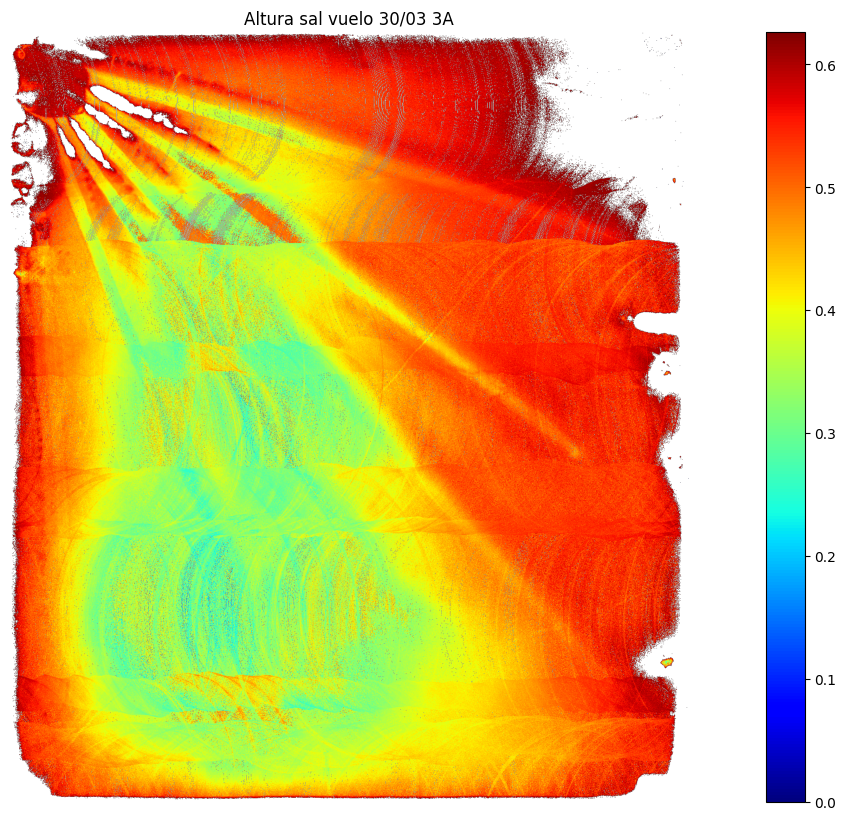

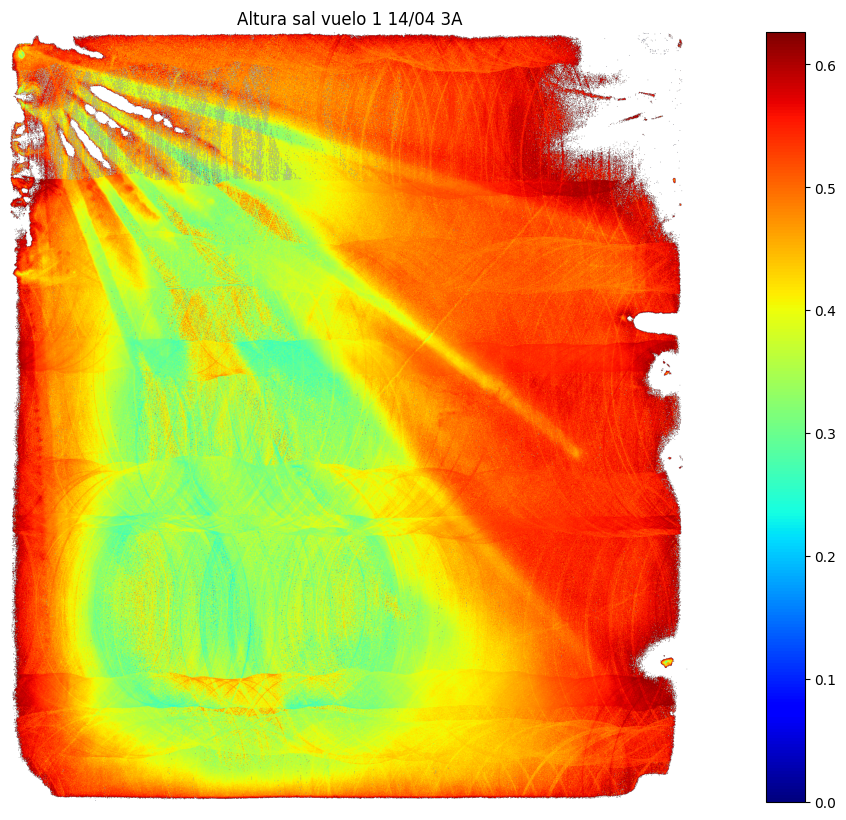

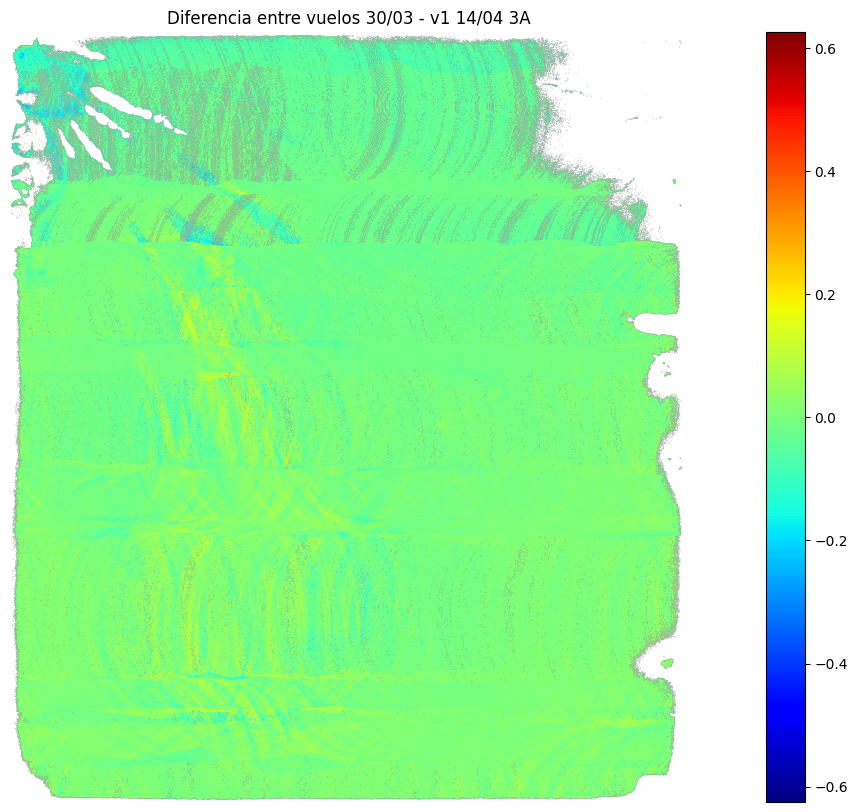

In [77]:

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(dem_a, cmap='jet')
plt.colorbar()
plt.title('Altura sal vuelo 30/03 3A')  
plt.axis('off')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(dem_b, cmap='jet')
plt.colorbar()
plt.title('Altura sal vuelo 1 14/04 3A')  
plt.axis('off')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(dem_b - dem_a, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title('Diferencia entre vuelos 30/03 - v1 14/04 3A')  
plt.show()


In [78]:
def bresenham_line(start=(10, 10), end=(10, 60)):
    # Unpack start and end points
    x1, y1 = np.array(start, dtype=np.int32).copy()
    x2, y2 = np.array(end, dtype=np.int32).copy()


    # Calculate differences
    dx = x2 - x1
    dy = y2 - y1

    # Determine if the line is steep (more vertical than horizontal)
    is_steep = abs(dy) > abs(dx)

    # Swap coordinates if the line is steep (for easier handling)
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Ensure the line is always drawn left-to-right
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1

    # Recalculate differences after the possible swap
    dx = x2 - x1
    dy = y2 - y1

    # Error term initialized to half of dx
    error = dx // 2
    ystep = 1 if y1 < y2 else -1  # Determines whether to increment or decrement y

    # List to store the generated points
    points = []
    y = y1

    # Main loop for Bresenham's algorithm
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)  # Swap x and y if the line is steep
        points.append(coord)

        # Update error term
        error -= abs(dy)

        # If error is negative, adjust y and reset the error term
        if error < 0:
            y += ystep
            error += dx

    return points

h, w = dem_a.shape
line = bresenham_line(start=(0, 0), end=(h-1,w-1))

(1554, 2) (1542, 2)


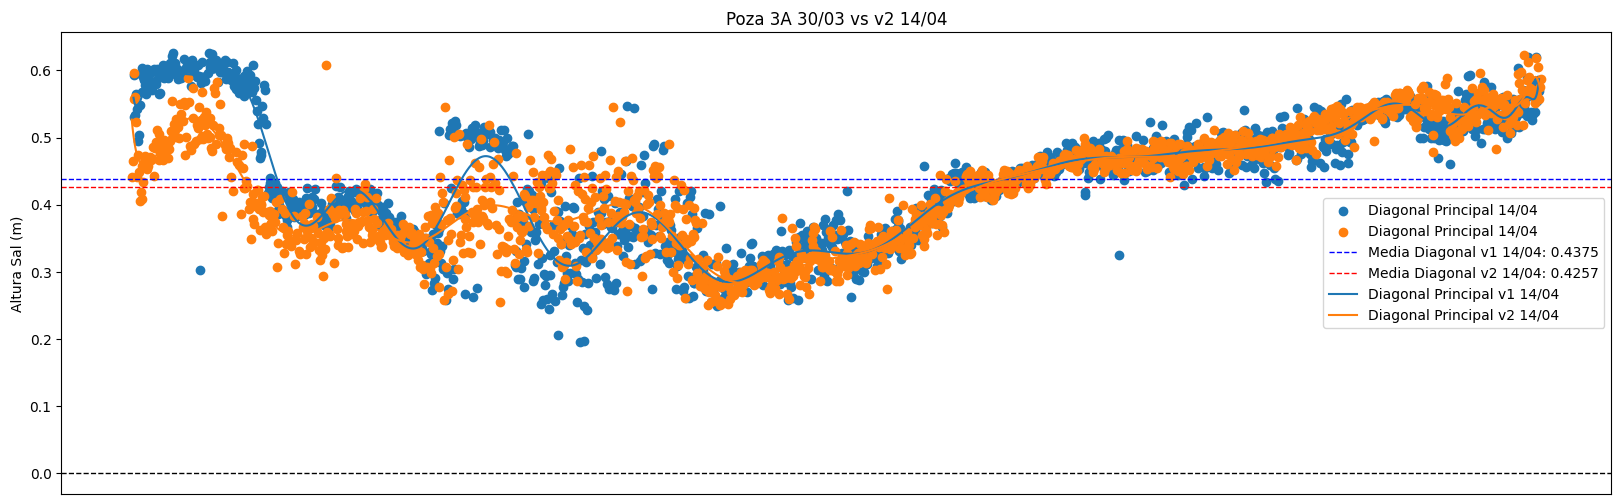

In [80]:

from numpy.polynomial.polynomial import Polynomial

z_d1 = np.array([(idx, dem_a[x][y]) for idx, (x, y) in enumerate(line) if not np.isnan(dem_a[x][y])])
z_d2 = np.array([(idx, dem_b[x][y]) for idx, (x, y) in enumerate(line) if not np.isnan(dem_b[x][y])])
print(z_d1.shape, z_d2.shape)

degree = 30
poly_d1 = Polynomial.fit(z_d1[:,0], z_d1[:,1], degree)
poly_d2 = Polynomial.fit(z_d2[:,0], z_d2[:,1], degree)

x_new_d1 = z_d1[:,0]
x_new_d2 = z_d2[:,0]
z_new_d1 = poly_d1(x_new_d1)
z_new_d2 = poly_d2(x_new_d2)

mean_diagonal1 = np.mean(z_d1[:,1])
mean_diagonal2 = np.mean(z_d2[:,1])

plt.figure(figsize=(20, 6))
plt.scatter(z_d1[:,0], z_d1[:,1], label='Diagonal Principal 14/04 ')
plt.scatter(z_d2[:,0], z_d2[:,1], label='Diagonal Principal 14/04')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(mean_diagonal1, color='blue', linestyle='--', linewidth=1, label=f'Media Diagonal v1 14/04: {mean_diagonal1:.4f}')
plt.axhline(mean_diagonal2, color='red', linestyle='--', linewidth=1, label=f'Media Diagonal v2 14/04: {mean_diagonal2:.4f}')
plt.plot(x_new_d1, z_new_d1, label='Diagonal Principal v1 14/04 ')
plt.plot(x_new_d2, z_new_d2, label='Diagonal Principal v2 14/04')
plt.title('Poza 3A 30/03 vs v2 14/04')
plt.ylabel('Altura Sal (m)')
plt.xticks([])
plt.legend()
plt.show()